In [86]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 11:38:35 2023 

The MPC controller takes in the previous RTN state computed (not the measured 'x' variable)
"""

import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from math import sqrt, sin, asin, cos, tan, atan2, pi
from numpy.linalg import norm, inv, pinv
from scipy.linalg import expm, sinm, cosm

from source import spacecraft
from aa273_control import *


In [87]:
##############################################################################
##############################################################################
###                                                                        ###
###               SETTING UP OF THE GPS CONSTELLATION BELOW                ###
###                                                                        ###
##############################################################################
##############################################################################

#region
# GPS Almanac Week 204: All available PRN IDs
prns = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         7, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]

# GPS Almanac Week 204: Semi-Major Axis [km]
GPS_SMAX = 26599.800

# GPS Almanac Week 204: Eccentricity [unitless]
GPS_ECCN = 0.000001

# GPS Almanac Week 204: Inclination [deg]
GPS_INCL = 55.0
        
# GPS Almanac Week 204: Right Angle of the Ascending Node [deg]
GPS_RAAN = [-143.881352, -149.446614,  -84.778512,  -22.818990,  -87.385619,
            -144.357305,   35.349176,  153.734801,  -26.028092,  -84.931462,
            -141.883192,   99.225855,  -16.924009,   97.083800,  -32.683446,
             100.277002,  158.759866, -143.755546,  161.314101,  -94.320245,
            -149.686511,  -86.467123,   30.236113,   94.562051,   91.458499,
             155.031466,   33.155708,  159.555151,   35.770562,   36.473751,
             -25.294003]

# GPS Almanac Week 204: Argument of Periapsis [deg]
GPS_ARGP = [  53.765545,  -75.631986,   57.743969, -173.043165,   64.681857,
             -46.573319, -127.231250,   13.148360,  112.699728, -139.444742,
            -154.121597,   76.981738,   53.130934, -176.496584,   67.669709,
              44.494200,  -81.162593, -178.499508,  128.866153, -166.197417,
             -45.969586, -177.202756,   50.789967,   59.425199,   26.153212,
              40.480607,   96.978207,  136.728158, -151.319311,   29.645619,
            -128.456075]

# GPS Almanac Week 204: Mean Anomaly [deg]
GPS_ANOM = [ -86.960177, -144.505126, -152.714424,   13.494215,   61.374757,
             -74.233353, -120.546970,   39.999955,   59.759746,  152.572997,
              -2.914681, -167.377052,   14.453008, -163.841686,  -15.388842,
              87.047746,   37.617981,  -80.040336,  160.861859,  -37.675960,
              36.690388, -139.207914,  -70.966229, -173.403954,  142.599792,
              40.680892,  147.604237,   43.801439, -129.846039, -157.112496,
              78.628936]

# Initialize both chief and deputy.
sc1_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800,   0.00827]
sc2_elements = [6918.14, 0.00722, 97.5976, 134.94389, -108.5025, -134.71026] 
sc1 = spacecraft.Spacecraft( elements = sc1_elements )
sc2 = spacecraft.Spacecraft( elements = sc2_elements )

# Set the chief of the spacecraft. Enable maneuvers for SC2.
sc2.chief = sc1 # ROEs and RTN states computed w.r.t. SC1


# Initialize GPS satellite osculating Keplerian elements
gps01oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 0], GPS_ARGP[ 0], GPS_ANOM[ 0]]
gps02oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 1], GPS_ARGP[ 1], GPS_ANOM[ 1]]
gps03oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 2], GPS_ARGP[ 2], GPS_ANOM[ 2]]
gps04oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 3], GPS_ARGP[ 3], GPS_ANOM[ 3]]
gps05oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 4], GPS_ARGP[ 4], GPS_ANOM[ 4]]
gps06oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 5], GPS_ARGP[ 5], GPS_ANOM[ 5]]
gps07oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 6], GPS_ARGP[ 6], GPS_ANOM[ 6]]
gps08oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 7], GPS_ARGP[ 7], GPS_ANOM[ 7]]
gps09oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 8], GPS_ARGP[ 8], GPS_ANOM[ 8]]
gps10oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 9], GPS_ARGP[ 9], GPS_ANOM[ 9]]
gps11oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[10], GPS_ARGP[10], GPS_ANOM[10]]
gps12oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[11], GPS_ARGP[11], GPS_ANOM[11]]
gps13oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[12], GPS_ARGP[12], GPS_ANOM[12]]
gps14oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[13], GPS_ARGP[13], GPS_ANOM[13]]
gps15oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[14], GPS_ARGP[14], GPS_ANOM[14]]
gps16oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[15], GPS_ARGP[15], GPS_ANOM[15]]
gps17oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[16], GPS_ARGP[16], GPS_ANOM[16]]
gps18oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[17], GPS_ARGP[17], GPS_ANOM[17]]
gps19oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[18], GPS_ARGP[18], GPS_ANOM[18]]
gps20oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[19], GPS_ARGP[19], GPS_ANOM[19]]
gps21oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[20], GPS_ARGP[20], GPS_ANOM[20]]
gps22oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[21], GPS_ARGP[21], GPS_ANOM[21]]
gps23oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[22], GPS_ARGP[22], GPS_ANOM[22]]
gps24oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[23], GPS_ARGP[23], GPS_ANOM[23]]
gps25oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[24], GPS_ARGP[24], GPS_ANOM[24]]
gps26oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[25], GPS_ARGP[25], GPS_ANOM[25]]
gps27oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[26], GPS_ARGP[26], GPS_ANOM[26]]
gps28oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[27], GPS_ARGP[27], GPS_ANOM[27]]
gps29oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[28], GPS_ARGP[28], GPS_ANOM[28]]
gps30oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[29], GPS_ARGP[29], GPS_ANOM[29]]
gps31oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[30], GPS_ARGP[30], GPS_ANOM[30]]

# Generate all GPS satellites at initial conditions.
gps01 = spacecraft.Spacecraft( elements = gps01oe )
gps02 = spacecraft.Spacecraft( elements = gps02oe )
gps03 = spacecraft.Spacecraft( elements = gps03oe )
gps04 = spacecraft.Spacecraft( elements = gps04oe )
gps05 = spacecraft.Spacecraft( elements = gps05oe )
gps06 = spacecraft.Spacecraft( elements = gps06oe )
gps07 = spacecraft.Spacecraft( elements = gps07oe )
gps08 = spacecraft.Spacecraft( elements = gps08oe )
gps09 = spacecraft.Spacecraft( elements = gps09oe )
gps10 = spacecraft.Spacecraft( elements = gps10oe )
gps11 = spacecraft.Spacecraft( elements = gps11oe )
gps12 = spacecraft.Spacecraft( elements = gps12oe )
gps13 = spacecraft.Spacecraft( elements = gps13oe )
gps14 = spacecraft.Spacecraft( elements = gps14oe )
gps15 = spacecraft.Spacecraft( elements = gps15oe )
gps16 = spacecraft.Spacecraft( elements = gps16oe )
gps17 = spacecraft.Spacecraft( elements = gps17oe )
gps18 = spacecraft.Spacecraft( elements = gps18oe )
gps19 = spacecraft.Spacecraft( elements = gps19oe )
gps20 = spacecraft.Spacecraft( elements = gps20oe )
gps21 = spacecraft.Spacecraft( elements = gps21oe )
gps22 = spacecraft.Spacecraft( elements = gps22oe )
gps23 = spacecraft.Spacecraft( elements = gps23oe )
gps24 = spacecraft.Spacecraft( elements = gps24oe )
gps25 = spacecraft.Spacecraft( elements = gps25oe )
gps26 = spacecraft.Spacecraft( elements = gps26oe )
gps27 = spacecraft.Spacecraft( elements = gps27oe )
gps28 = spacecraft.Spacecraft( elements = gps28oe )
gps29 = spacecraft.Spacecraft( elements = gps29oe )
gps30 = spacecraft.Spacecraft( elements = gps30oe )
gps31 = spacecraft.Spacecraft( elements = gps31oe )

# endregion

# Group all GPS satellites together into a constellation.
gps_constellation = [ gps01, gps02, gps03, gps04, gps05, gps06, gps07, gps08,
                      gps09, gps10, gps11, gps12, gps13, gps14, gps15, gps16,
                      gps17, gps18, gps19, gps21, gps22, gps23, gps24, gps25,
                      gps25, gps26, gps27, gps28, gps29, gps30, gps31 ]
# end region

In [88]:
##############################################################################
##############################################################################
###                                                                        ###
###              AUXILIARY FUNCTIONS FOR GPS CONSTELLATION                 ###
###                                                                        ###
##############################################################################
##############################################################################
def get_hill_frame(r, v):
    h = np.cross(r, v)  # Angular momentum vector
    r_hat = r / np.linalg.norm(r)  # Local X-axis (R)
    h_hat = h / np.linalg.norm(h)  # Local Z-axis (N)
    y_hat = np.cross(h_hat, r_hat)  # Local Y-axis (T)
    return np.array([r_hat, y_hat, h_hat])

def rtn_to_eci(target_ECI, chaser_RTN):
    r_target = target_ECI[0:3]
    v_target = target_ECI[3:6]
    r_chaser = chaser_RTN[0:3]
    v_chaser = chaser_RTN[3:6]
    matrix_rtn2eci = get_hill_frame(r_target, v_target)
    nuDot = norm(np.cross(r_target, v_target)) / (norm(r_target)**2)
    omega = np.array([0.0, 0.0, nuDot])
    rho = np.transpose(matrix_rtn2eci) @ r_chaser
    rhoDot = np.transpose(matrix_rtn2eci) @ (v_chaser + np.cross(omega, r_chaser))
    
    chaser_relative_ECI = np.zeros(6)
    chaser_relative_ECI[0:3] = rho
    chaser_relative_ECI[3:6] = rhoDot

    chaser_ECI = chaser_relative_ECI + target_ECI
    return chaser_ECI # Chaser in ECI frame

def eci_to_rtn(target_ECI, chaser_ECI):
    r_target = target_ECI[0:3]
    v_target = target_ECI[3:6]

    chaser_relative_ECI = chaser_ECI - target_ECI
    rho = chaser_relative_ECI[0:3]
    rhoDot = chaser_relative_ECI[3:6]

    nuDot = norm(np.cross(r_target, v_target)) / (norm(r_target)**2)
    omega = np.array([0.0, 0.0, nuDot])
    matrix_rtn2eci = get_hill_frame(r_target, v_target)

    r_chaser = matrix_rtn2eci @ rho
    v_chaser = matrix_rtn2eci @ rhoDot - np.cross(omega, r_chaser)

    chaser_RTN = np.zeros(6)
    chaser_RTN[0:3] = r_chaser
    chaser_RTN[3:6] = v_chaser

    return chaser_RTN # Chaser in RTN frame

def rv_rtn_to_eci(rv_c_eci, r_rtn, v_rtn):
    r = rv_c_eci[0:3]
    v = rv_c_eci[3:6]
    matrix_eci2rtn = get_hill_frame(r, v)
    nuDot = norm(np.cross(r, v)) / (norm(r)**2)
    omega = np.array([0.0, 0.0, nuDot])
    rho = np.transpose(matrix_eci2rtn) @ r_rtn
    rhoDot = np.transpose(matrix_eci2rtn) @ (v_rtn + np.cross(omega, r_rtn))
    rv_cd_eci = np.zeros(6)
    rv_cd_eci[0:3] = rho
    rv_cd_eci[3:6] = rhoDot
    return rv_cd_eci # This returns the RELATIVE state in ECI

def rv_eci_to_rtn(rv_c_eci, rv_cd_eci):
    r = rv_c_eci[0:3]
    v = rv_c_eci[3:6]
    rho = rv_cd_eci[0:3]
    rhoDot = rv_cd_eci[3:6]
    nuDot = norm(np.cross(r, v)) / (norm(r)**2)  # true anomaly derivative
    omega = np.array([0.0, 0.0, nuDot])
    matrix_eci2rtn = get_hill_frame(r, v)
    r_rtn = matrix_eci2rtn @ rho
    v_rtn = matrix_eci2rtn @ rhoDot - np.cross(omega, r_rtn)
    
    return r_rtn, v_rtn

In [89]:

# Function to convert ECEF (xyz) to Geodetic (lat-lon-alt) coordinates
def ecef_to_geodetic(pos):
    if len(pos) != 3:
        raise ValueError('ECEF to Geodetic: Position vector must be length 3!')
        return np.array([0,0,0])
    earthRad = 6378136.300       # Radius of Earth (WGS84)
    earthEcc = 0.081819190842622 # Earth eccentricity (WGS84)
    x, y, z, r = pos[0], pos[1], pos[2], norm(pos)
    lon = atan2(y,x)
    lat0 = asin(z/r) 
    lat = lat0 # Initial guess
    n, nMax = 0, 3 # Number of iterations
    error, tol = 1, 1E-12
    rxy = norm([x,y])
    while (error > tol) and (n < nMax):
        lat0 = lat
        N = earthRad / sqrt(1 - (earthEcc * sin(lat0))**2)
        lat = atan2(z + (N * earthEcc * earthEcc) * sin(lat0), rxy)
        error = abs(lat - lat0)
        n += 1
    alt = (rxy - cos(lat)) - N
    geodetic = np.array([lat, lon, alt])
    return geodetic

# Computes the azimuth, elevation, and range from positions 0 to 1
def compute_aer(pos0, pos1):
    lla = ecef_to_geodetic(pos0)
    lat, lon = lla[0], lla[1]
    so = sin(lon)
    co = cos(lon)
    sa = sin(lat)
    ca = cos(lat)
    rotation = np.array(
        [[-so,            co, 0.0],
         [-sa * co, -sa * so, ca ],
         [ ca * co,  ca * so, sa ]])
    enu = rotation @ (pos1 - pos0)
    azim = atan2(enu[0], enu[1]);
    elev = atan2(enu[2], norm(enu[0:2]));
    rnge = norm(enu);
    enu = np.array([azim, elev, rnge]);
    return enu


In [90]:
##############################################################################
##############################################################################
###                                                                        ###
###               FUNCTIONS TO COMPUTE JACOBIANS FOR FILTER                ###
###                                                                        ###
##############################################################################
##############################################################################

# Computes the state transition matrix for absolute orbital motion
# It requires rough knowledge on the norm of the S/C pose

def compute_A(dt, R):
    GM = 398600.4418
    F = -(GM / (R**3)) * dt
    A = np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [F, 0, 0, 1, 0, 0],
        [0, F, 0, 0, 1, 0],
        [0, 0, F, 0, 0, 1]])
    return A

# Computes the Jacobian of a single scalar range measurement
def compute_C(rho, pos_rcv, pos_gps):
    dx = pos_rcv[0] - pos_gps[0]
    dy = pos_rcv[1] - pos_gps[1]
    dz = pos_rcv[2] - pos_gps[2]
    C = np.array([ dx/rho, dy/rho, dz/rho, 0, 0, 0 ])
    return C

# Computes the Jacobian of a single scalar Doppler measurement
def compute_Cdot(pos_rcv, pos_gps, vel_rcv, vel_gps):
    dpos = pos_gps - pos_rcv
    dvel = vel_gps - vel_rcv
    rho = norm(pos_gps - pos_rcv)
    prx = -1 * dvel[0] / rho
    pry = -1 * dvel[1] / rho
    prz = -1 * dvel[2] / rho
    pvx = -1 * dpos[0] / rho
    pvy = -1 * dpos[1] / rho
    pvz = -1 * dpos[2] / rho
    Cdot = np.array([ prx, pry, prz, pvx, pvy, pvz ])
    return Cdot

def compute_A_rel(x, dt):
    GM = 398600.4418
    a = np.linalg.norm(x[0:3]) #approximation for circular orbit
    n = np.sqrt(GM/a**3)
    c = np.cos(dt*n)
    s = np.sin(dt*n)
    A = np.array([
        [4-3*c, 0, 0, s/n, 2/n*(1-c), 0],
        [-6*n*dt + 6*s, 1, 0, 2/n*(c-1), 4*s/n-3*dt, 0],
        [0, 0, c, 0, 0, s/n],
        [3*n*s, 0, 0, c, 2*s, 0],
        [6*n*(c-1), 0, 0, -2*s, -3+4*c, 0],
        [0, 0, -n*s, 0, 0, c]])
    return A
    
def compute_C_bearing(x):
    r,t,n = x[6:9]
    rt_norm = np.sqrt(r**2+t**2);
    rtn_norm = np.sqrt(r**2+t**2+n**2);
    #C = np.array([
     #   [r/rtn_norm, t/rtn_norm, n/rtn_norm, 0, 0, 0],
       # [-r*t/(np.abs(r)*rt_norm**2), np.abs(r)/rt_norm**2, 0, 0, 0, 0],
        #[-r*n/(rt_norm*rtn_norm**2), -t*n/(rt_norm*rtn_norm**2),  rt_norm/rtn_norm**2, 0, 0, 0]
    #])
    C = np.array([
        [r/rtn_norm, t/rtn_norm, n/rtn_norm, 0, 0, 0],
        [t/(rt_norm**2), -r/rt_norm**2, 0, 0, 0, 0],
        [-r*n/(rt_norm*rtn_norm**2), -t*n/(rt_norm*rtn_norm**2),  rt_norm/rtn_norm**2, 0, 0, 0]
    ])
    #C = np.array([
     #   [1, 0, 0, 0, 0, 0],
      #  [0, 1, 0, 0, 0, 0],
       # [0, 0, 1, 0, 0, 0]]) 
    return C

def angle_measure(x,R):
    r,t,n = x[6:9]
    #theta = np.arcsin(r/np.sqrt(r**2+t**2))
    #phi = np.arcsin(n/np.sqrt(r**2+t**2+n**2))
    theta = np.arctan2(r,t)
    phi = np.arctan2(n,np.sqrt(r**2+t**2))
    d = np.linalg.norm(x[6:9])
    y = np.array([d,theta,phi])
    y = y + np.random.multivariate_normal(np.zeros(3), R)
    
    #y = np.array([theta,phi])
    #y = y + np.random.multivariate_normal(np.zeros(2), R)
    
    #y = np.array([d])
    #y = y + np.random.multivariate_normal(np.zeros(1), R)    
        
    #y = np.array([r,t,n])
    return y

def update_state(x,u,dt):
    rv_chaser_eci = x[0:6]
    r_target_rtn = x[6:9]
    v_target_rtn = x[9:]
    rv_target_eci = rv_chaser_eci + rv_rtn_to_eci(rv_chaser_eci, r_target_rtn, v_target_rtn)
    
    sc_target_dummy = spacecraft.Spacecraft(states = rv_target_eci)
    sc_chaser_dummy = spacecraft.Spacecraft(states = rv_chaser_eci)
    sc_chaser_dummy.set_force_frame('ECI')
    sc_chaser_dummy.forces['maneuvers'] = True
    
    sc_chaser_dummy.set_thruster_acceleration = u
    sc_chaser_dummy.propagate_perturbed(dt, dt)
    sc_target_dummy.propagate_orbit(dt)
    
    rv_chaser_eci = np.array([sc_chaser_dummy.px, sc_chaser_dummy.py, sc_chaser_dummy.pz, sc_chaser_dummy.vx, sc_chaser_dummy.vy, sc_chaser_dummy.vz])
    rv_target_eci = np.array([sc_target_dummy.px, sc_target_dummy.py, sc_target_dummy.pz, sc_target_dummy.vx, sc_target_dummy.vy, sc_target_dummy.vz])
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_chaser_eci, rv_target_eci - rv_chaser_eci)
    x = np.array([sc_chaser_dummy.px, sc_chaser_dummy.py, sc_chaser_dummy.pz, sc_chaser_dummy.vx, sc_chaser_dummy.vy, sc_chaser_dummy.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])  
    
    return x

In [91]:

##############################################################################
##############################################################################
###                                                                        ###
###               SETTING UP OF THE ACTUAL FLIGHT SIMULATION               ###
###                                                                        ###
##############################################################################
##############################################################################
dt = 0.2
duration = 500

#dt = 10;
#duration = 10000;
timesteps = math.floor(duration / dt)


P_cost = np.eye(6)*1e3 # terminal state cost matrix
Q_cost = np.diag([1, 1, 1, 1, 1, 1]) # state cost matrix
R_cost = 1*np.eye(3) # control cost matrix

N = 7 # MPC step horizon
max_iters = 200 # maximum number of iterations for SCP  
eps = 1 # tolerance for SCP

#Define Spacecrafts
sc1_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800, -99.02]
#sc1_elements = [6918.14, 0.0011, 97.59760, 45, -109.33800,   0.01001]
sc1 = spacecraft.Spacecraft( elements = sc1_elements )

target_sc_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800,  -99]
#target_sc_elements = [6918.14, 0.001, 97.6, 45.002, -109.338, 0.01]
sc_target = spacecraft.Spacecraft( elements = target_sc_elements )

sc1.forces['maneuvers'] = True
sc1.set_force_frame('ECI')

# Setup the process and measurement noise
Q = np.diag([dt/100, dt/100, dt/100, dt/100000, dt/100000, dt/100000, dt/100, dt/100, dt/100, dt/100000, dt/100000, dt/100000])
R = 0.005; # 5m/s
Rdot = 0.000005; # 5mm/s
R_bearing = np.diag([.00000000001,.0000001,.0000001]) # rad
#R_bearing = np.diag([.000000001,.000000001]) # rad
#Q = np.diag([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#R = 0.00; # 5m/s
#Rdot = 0.00000; # 5mm/s
#R_bearing = np.diag([.0000000000,.000000,.000000]) # rad

# Initialize the state history
chaser_ECI_history = np.zeros((timesteps, 6))
target_ECI_history = np.zeros((timesteps, 6))
chaser_RTN_history = np.zeros((timesteps, 6))
chaser_MPC_history = np.zeros((timesteps, N-1, 6))
thrust_history = np.zeros((timesteps, 3))
error_history = np.zeros(timesteps)
u_ECI = np.zeros(3)

# Setup the initial state and initial (prior) distribution
rv_target_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
rv_sc1_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
rtn_pos, rtn_vel = rv_eci_to_rtn(rv_sc1_eci, rv_target_eci - rv_sc1_eci)
x = np.array([ sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])
print(1000*x[6:])

#x = x + np.random.multivariate_normal(np.zeros(12), np.diag([.0001, .0001, .0001, .0001, .000001, .000001, .0000, .0000, .0000, .0000001, .0000001, .0000001]))
P = 1000 * np.eye(12) # Filter prior distribution covariance

# Matrices to record measured and true state history
xt_history = np.zeros((12, timesteps)); # Truth
xp_history = np.zeros((12, timesteps));  # test propagated mean
x_history = np.zeros((12, timesteps));  # Filter mean
P_history = np.zeros((12, timesteps));  # Filter variance
k = 1;                               # Counter

# Set the elevation angle masking (default 5 degrees)
elevMask = np.deg2rad(5.0)


[-4.45326024e-01  2.41488259e+03 -1.68453296e-10 -4.16367288e-06
  2.61682539e-05 -2.42160225e-13]


In [92]:
##############################################################################
##############################################################################
###                                                                        ###
###                    ACTUAL FLIGHT SIMULATION BELOW                      ###
###                                                                        ###
##############################################################################
##############################################################################
print(timesteps)

# For loop, generate ground truth `xt` and noisy measurements `y`.
for k in range(timesteps):
    print('---timestep: ', k)
    
    # compute chaser relative state in target RTN
    rv_chaser_eci = x[0:6]
    r_target_rtn = x[6:9]
    v_target_rtn = x[9:]
    rv_target_eci = rv_chaser_eci + rv_rtn_to_eci(rv_chaser_eci, r_target_rtn, v_target_rtn)
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_target_eci, rv_chaser_eci - rv_target_eci)
    chaser_RTN = np.hstack((rtn_pos, rtn_vel))
    
    rv_target_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    rv_sc1_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_target_eci, rv_chaser_eci - rv_target_eci)
    chaser_RTN_true = np.hstack((rtn_pos, rtn_vel))
    # print('######')
    # print(chaser_RTN)
    # print(chaser_RTN_true)
    # print('######')

    
    # Record states
    x_history[:,k] = x
    P_history[:,k] = [P[0,0], P[1,1], P[2,2], P[3,3], P[4,4], P[5,5],P[6,6], P[7,7], P[8,8], P[9,9], P[10,10], P[11,11]]
    rv_target_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    rv_sc1_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_sc1_eci, rv_target_eci - rv_sc1_eci)
    xt_history[:,k] = np.array([ sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])
    target_eci_k = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    chaser_eci_k = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
    chaser_ECI_history[k, :] = chaser_eci_k
    target_ECI_history[k, :] = target_eci_k
    chaser_RTN_history[k, :] = chaser_RTN
    
    # Use MPC to compute the optimal control input
    # MPC begins at previous state (takes in RTN) and attempts to reach origin in RTN frame
    
    x_mpc, u_mpc = do_MPC(dt, sc1.n, sc1.mass, chaser_RTN, np.zeros(6), N, Q_cost, R_cost, P_cost, max_iters, eps)
    chaser_MPC_history[k, :, :] = x_mpc[2:, :]

    # Convert the MPC output to ECI
    eci_2_hill = get_hill_frame(target_eci_k[0:3], target_eci_k[3:6])
    hill_2_eci = np.transpose(eci_2_hill)
    u_ECI =  hill_2_eci @ u_mpc[1, :]
    thrust_history[k, :] = u_ECI
    
    # Propagate the true states of all spacecraft using RK4 propagator
    #u_ECI = np.zeros(3)
    sc1.set_thruster_acceleration(u_ECI/sc1.mass) # u_ECI/sc1.mass
    sc1.propagate_perturbed(dt, dt)
    
    sc_target.propagate_orbit(dt)
    for gps in gps_constellation:
        gps.propagate_orbit(dt)
    
     # Propagate the filter with the time update here.
    A11 = compute_A( dt, norm(x[0:3]))
    A12 = np.zeros([6,6])
    A21 = np.zeros([6,6])
    A22 = compute_A_rel(x, dt)
    A = np.block([[A11,A12],[A21,A22]])
    
    #x = A @ x # Add the linearized control mapping here?
    ###
    x = update_state(x,u_ECI/sc1.mass,dt)
    ###
    
    P = A @ P @ np.transpose(A) + Q
    Z = np.zeros([1,6])   
    Z3 = np.zeros([3,6]) 
    # Check which GPS satellites the SC can currently see. If it can
    # detect and receive range, compute a measurement update.
    for prn in prns:
        gps = gps_constellation[prn-1]
        pos_sc1 = np.array([sc1.px, sc1.py, sc1.pz])
        pos_gps = np.array([gps.px, gps.py, gps.pz])
        aer = compute_aer(pos_sc1, pos_gps)
        elev = aer[1]
        if elev > elevMask:
            
            # Observed and computed pseudorange measurement
            y = norm(pos_sc1 - pos_gps) + np.random.normal(0, R)
            yc = norm(x[0:3] - pos_gps)

            # Compute Jacobian and Kalman gain for position update
            C = compute_C( y, pos_sc1, pos_gps)
            C = np.block([C, Z])
            CT = np.transpose(C)

            K = P @ CT / ((C @ P @ CT) + R)
            x = x + np.squeeze(K * (y-yc))
            P = P - (np.outer(K,C) @ P)

            
            # Observed and computed Doppler measurement
            vel_sc1 = np.array([sc1.vx, sc1.vy, sc1.vz])
            vel_gps = np.array([gps.vx, gps.vy, gps.vz])
            dvel = vel_gps - vel_sc1
            los = (pos_gps - pos_sc1) / norm(pos_gps - pos_sc1)
            losc = (pos_gps - x[0:3]) / norm(pos_gps - x[0:3])
            ydot = np.dot(dvel, los)
            ycdot = np.dot(vel_gps - x[3:6], losc)
            
            # Compute Jacobian and Kalman gain for velocity update
            Cdot = compute_Cdot( x[0:3], pos_gps, x[3:6], vel_gps )
            Cdot = np.block([Cdot, Z])
            CdotT = np.transpose(Cdot)

            K = P @ CdotT / ((Cdot @ P @ CdotT) + Rdot)
            x = x + np.squeeze(K * (ydot-ycdot))
            P = P - (np.outer(K,Cdot) @ P)

            
    
   # Compute Jacobian and Kalman gain for relative position update
    rv_target_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    rv_sc1_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_sc1_eci, rv_target_eci - rv_sc1_eci)
    xt_curr = np.array([ sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])
    y = angle_measure(xt_curr,R_bearing)
    yc = angle_measure(x,np.zeros([3,3]))
    C = compute_C_bearing(x)
    C = np.block([Z3,C])
    CT = np.transpose(C)
    K = P @ CT @ np.linalg.inv((C @ P @ CT) + R_bearing) #replace this with solve
    x = x + np.squeeze(K @ (y-yc))
    P = P - (K@ C @ P) 
    ##################

    # Check error between target and chaser aka how far chaser is from origin in RTN frame
    error = np.linalg.norm(chaser_RTN[0:3])
    if (error < 0.25):
        print('Target reached!')
        break
    elif (error > 2e3):
        print('all hope is lost :(')
        break
    else:
        print('Error: ', error)
        error_history[k] = error

    # u_ECI = np.zeros(3)

x_history  = x_history * 1000
xt_history = xt_history * 1000
xp_history = xp_history * 1000
P_history = P_history * 1000**2  

    


2500
---timestep:  0
Converged in 2 iterationss
Error:  2.4148826279077875
---timestep:  1
Converged in 2 iterationss
Error:  2.4149046405633907
---timestep:  2
Converged in 2 iterationss
Error:  2.4195720299647347
---timestep:  3
Converged in 2 iterationss
Error:  2.4196062570922585
---timestep:  4
Converged in 2 iterationss
Error:  2.4158929456065525
---timestep:  5
Converged in 2 iterationss
Error:  2.4153018674443754
---timestep:  6
Converged in 2 iterationss
Error:  2.414969904090907
---timestep:  7
Converged in 2 iterationss
Error:  2.4148140696083957
---timestep:  8
Converged in 2 iterationss
Error:  2.414656787369411
---timestep:  9
Converged in 2 iterationss
Error:  2.414527975708167
---timestep:  10
Converged in 2 iterationss
Error:  2.414406027337421
---timestep:  11
Converged in 2 iterationss
Error:  2.4142555945418422
---timestep:  12
Converged in 2 iterationss
Error:  2.414139058056423
---timestep:  13
Converged in 2 iterationss
Error:  2.413964140968374
---timestep:  14


In [93]:
# print(u_mpc)
min_err = np.min(error_history[0:k])
print('Minimum error: ', min_err)
min_err_idx = np.argmin(error_history[0:k])
print('Minimum error index: ', min_err_idx)
improvement = (error_history[0] - min_err)
print('Improvement: ', improvement)

# print position at min error
print('Position at min error: ', chaser_RTN_history[min_err_idx, 0:3])

final_it = k
# print([np.linalg.norm(u_mpc[i], np.inf) for i in range(N-1)])

Minimum error:  0.25029105164676924
Minimum error index:  646
Improvement:  2.164591576261018
Position at min error:  [-1.09004728e-02 -2.50053571e-01  4.54252939e-05]


In [94]:
timeAxis = np.linspace( 0, duration, timesteps)
stdev = np.sqrt(P_history)

plt.rcParams['figure.figsize'] = [15, 5]
font = {'weight' : 'bold',
        'size'   : 22}


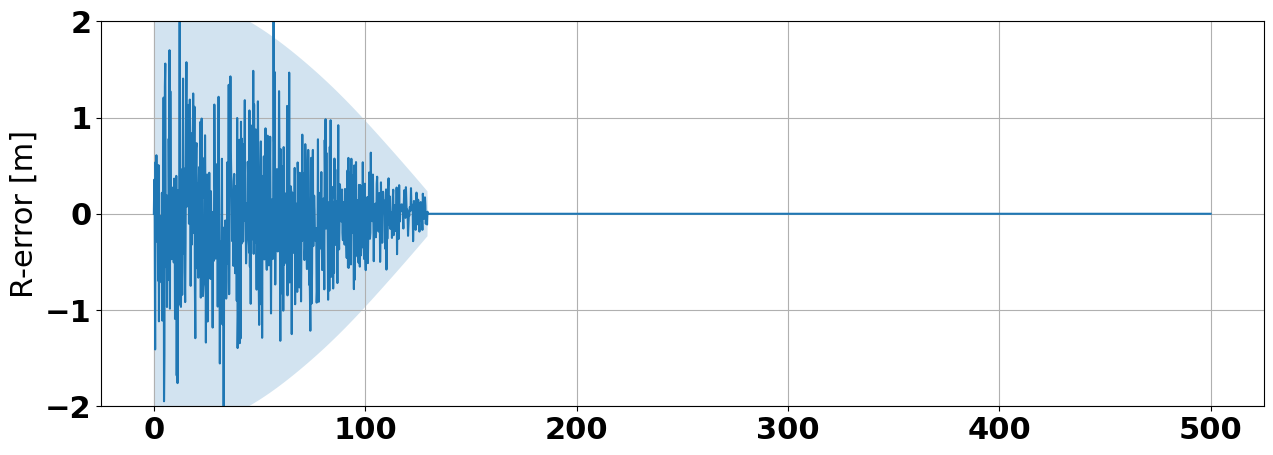

In [95]:
matplotlib.rc('font', **font)
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:], xt_history[6,:] - x_history[6,:])
axb.fill_between( timeAxis[:], 3*stdev[6,:], -3*stdev[6,:], alpha=0.2 )
axb.set_ylim(-2, 2)
axb.set_ylabel('R-error [m]')
axb.grid()

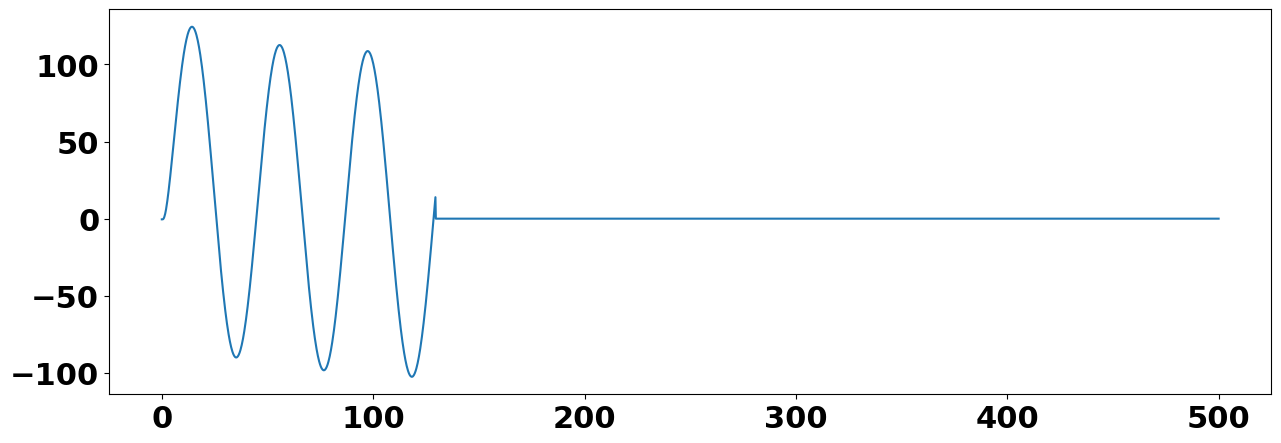

In [96]:
figb, axb = plt.subplots()
axb.plot(timeAxis[:], xt_history[6,:])

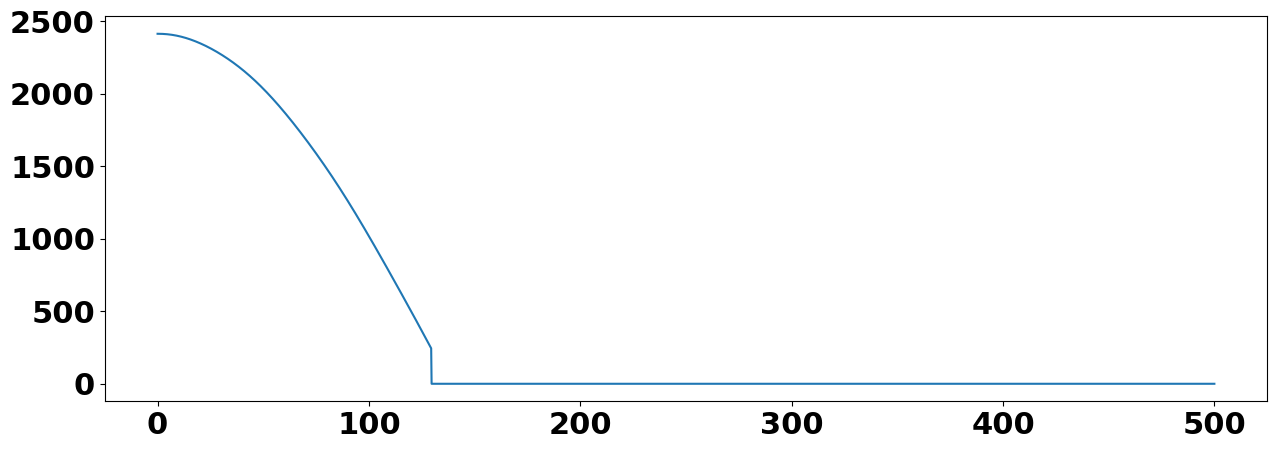

In [97]:
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:],  xt_history[7,:])

In [98]:
print( x_history[6,:])

[-0.44532602 -0.79628834 -0.3924865  ...  0.          0.
  0.        ]


In [102]:
# ##############################################################################
# ##############################################################################
# ###                                                                        ###
# ###                               PLOTTING                                 ###
# ###                                                                        ###
# ##############################################################################
# ##############################################################################
print(timesteps)
%matplotlib tk
# Plot the trajectory of the chaser and target in ECI frame
plt.figure()
plt.plot(chaser_ECI_history[1:k, 0], chaser_ECI_history[1:k, 1], 'bo', label='Chaser')
plt.plot(target_ECI_history[1:k, 0], target_ECI_history[1:k, 1], 'ro', label='Target')
plt.plot(chaser_ECI_history[1, 0], chaser_ECI_history[1, 1], '*', label='Chaser Initial')
plt.plot(chaser_ECI_history[k, 0], chaser_ECI_history[k, 1], '*', label='Chaser Final')
plt.plot(target_ECI_history[1, 0], target_ECI_history[1, 1], '*', label='Target Initial')
plt.plot(target_ECI_history[k, 0], target_ECI_history[k, 1], 'k*', label='Target Final')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Trajectory of Chaser and Target in ECI frame')
plt.legend()

# Plot the trajectory of the chaser in RTN frame
plt.figure()
plt.plot(chaser_RTN_history[1:k+1, 0], chaser_RTN_history[1:k+1, 1], 'b', label='Chaser')
plt.plot(chaser_RTN_history[1, 0], chaser_RTN_history[1, 1], '*', label='Chaser Initial')
plt.plot(chaser_RTN_history[k, 0], chaser_RTN_history[k, 1], '*', label='Chaser Final')


time_arr = np.arange(0, math.floor(k / dt), 20)
# for t in time_arr:
#     plt.plot(chaser_MPC_history[t, 0:N, 0], chaser_MPC_history[t, 0:N, 1], '--*', color='k')
plt.plot(0, 0, 'x', label='Target')
# plt.plot(chaser_RTN_history[min_err_idx, 0], chaser_RTN_history[min_err_idx, 1], 'x', label='Minimum Error')
plt.xlabel('R [km]')
plt.ylabel('T [km]')
plt.title('Trajectory of Chaser in RTN frame')
plt.legend()

# Plot 3D plot
plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = chaser_RTN_history[1:, 2]
xline = chaser_RTN_history[1:, 0]
yline = chaser_RTN_history[1:, 1]
ax.plot3D(xline, yline, zline, 'blue', label='Chaser')
ax.plot3D(xline[0], yline[0], zline[0], '*', label='Chaser Initial')
ax.plot3D(xline[-1], yline[-1], zline[-1], '*', label='Chaser Final')
ax.plot3D(0, 0, 0, 'x', label='Target')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')

# Plot thrust history
plt.figure()
plt.plot(thrust_history[:, 0], label='x')
plt.plot(thrust_history[:, 1], label='y')
plt.plot(thrust_history[:, 2], label='z')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
plt.title('Thrust History')
plt.legend()

# Plot error history
plt.figure()
plt.plot(error_history)
plt.xlabel('Time [s]')
plt.ylabel('Error [km]')
plt.title('Error History (L2-norm distance from origin)')



2500


Text(0.5, 1.0, 'Error History (L2-norm distance from origin)')

In [100]:

# plt.close('all')


# # Convert km to m
# x_history  = x_history * 1000
# xtrue_history = xtrue_history * 1000
# target_true_history = target_true_history * 1000

# # Trajectory
# plt.figure()
# plt.title('Trajectory')
# q = 0
# plt.plot( xtrue_history[0, q:], xtrue_history[1, q:], 'b', label=' Chaser Truth')
# plt.plot( x_history[0, q:], x_history[1, q:], 'r', label=' Chaser Estimate')
# plt.plot(x_history[0, q], x_history[1, q], '*', label=' Chaser Start')
# plt.xlabel('X [km]')

# plt.plot(target_true_history[0,:], target_true_history[1,:], 'g', label=' Target Truth')
# plt.legend()

# plt.figure()


# # RTN Positions
# plt.title('RTN Positions')
# for t in range (29):
#     plt.plot(x_MPC_history[0, 0:4, t], x_MPC_history[1, 0:4, t], '--*', color='k')
# plt.plot(x_RTN_history[0,:], x_RTN_history[1,:], '-o', label=' Chaser Estimate')
# plt.plot(x_RTN_truth[0,:], x_RTN_truth[1,:], '-o', label=' Chaser Truth')
# plt.plot(x_RTN_history[0, q], x_RTN_history[1, q], '*', label=' Chaser Position')
# plt.plot(x_RTN_history[0, 0], x_RTN_history[1, 0], '*', label=' Chaser Start')
# plt.plot(0, 0, '*', label=' Target')

# plt.legend()

# plt.figure()
# plt.title('Control input')
# plt.plot(u_history[0,:], label='u_x')
# plt.plot(u_history[1,:], label='u_y')
# plt.plot(u_history[2,:], label='u_z')
# plt.xlim(0, 30)
# plt.ylabel('Force')
# plt.xlabel('Time steps (3000 sec)')
# plt.legend()

# #show plot
# plt.show()
